<a href="https://colab.research.google.com/github/avbarbaros/numerical-integrators/blob/main/numerical_integrators_with_oop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Numerical Integration Framework with OOP**

A comprehensive implementation of numerical integrators with abstract base classes

In [1]:
from abc import ABC, abstractmethod
import numpy as np
from typing import Callable, Tuple, Optional
import matplotlib.pyplot as plt
from dataclasses import dataclass

# =============================================================================
# Part 1: Abstract Base Class
# =============================================================================

@dataclass
class IntegrationResult:
    """Data class to store integration results"""
    value: float
    error_estimate: Optional[float] = None
    num_evaluations: int = 0
    method: str = ""

    def __str__(self):
        error_str = f"{self.error_estimate:.2e}" if self.error_estimate else "N/A"
        return (f"Method: {self.method}\n"
                f"Value: {self.value:.10f}\n"
                f"Error Estimate: {error_str}\n"
                f"Function Evaluations: {self.num_evaluations}")


class NumericalIntegrator(ABC):
    """
    Abstract base class for numerical integrators.
    Defines the interface that all concrete integrators must implement.
    """

    def __init__(self, function: Callable[[float], float]):
        """
        Initialize the integrator with a function to integrate.

        Args:
            function: The function to integrate, f(x)
        """
        self.function = function
        self.eval_count = 0

    def _evaluate(self, x: float) -> float:
        """
        Evaluate the function and track the number of evaluations.

        Args:
            x: Point at which to evaluate the function

        Returns:
            Function value at x
        """
        self.eval_count += 1
        return self.function(x)

    def reset_counter(self):
        """Reset the function evaluation counter"""
        self.eval_count = 0

    @abstractmethod
    def integrate(self, a: float, b: float, **kwargs) -> IntegrationResult:
        """
        Perform numerical integration from a to b.

        Args:
            a: Lower bound of integration
            b: Upper bound of integration
            **kwargs: Additional method-specific parameters

        Returns:
            IntegrationResult object containing the result and metadata
        """
        pass

    @abstractmethod
    def estimate_error(self, a: float, b: float, **kwargs) -> float:
        """
        Estimate the error of the integration.

        Args:
            a: Lower bound of integration
            b: Upper bound of integration
            **kwargs: Additional method-specific parameters

        Returns:
            Error estimate
        """
        pass



In [2]:
# =============================================================================
# Part 2: Concrete Implementations
# =============================================================================

class TrapezoidalIntegrator(NumericalIntegrator):
    """
    Trapezoidal rule integrator.
    Uses linear approximation between points.
    Error: O(h^2) where h = (b-a)/n
    """

    def integrate(self, a: float, b: float, n: int = 100) -> IntegrationResult:
        """
        Integrate using the trapezoidal rule.

        Args:
            a: Lower bound
            b: Upper bound
            n: Number of subintervals

        Returns:
            IntegrationResult object
        """
        self.reset_counter()
        h = (b - a) / n

        # Evaluate endpoints
        result = (self._evaluate(a) + self._evaluate(b)) / 2.0

        # Evaluate interior points
        for i in range(1, n):
            x = a + i * h
            result += self._evaluate(x)

        result *= h

        # Estimate error using Richardson extrapolation
        error = self.estimate_error(a, b, n=n)

        return IntegrationResult(
            value=result,
            error_estimate=error,
            num_evaluations=self.eval_count,
            method="Trapezoidal Rule"
        )

    def estimate_error(self, a: float, b: float, n: int = 100) -> float:
        """
        Estimate error using Richardson extrapolation.
        Compare results with n and 2n intervals.

        Args:
            a: Lower bound
            b: Upper bound
            n: Number of subintervals

        Returns:
            Error estimate
        """
        # Compute with n intervals
        I_n = self._trapezoidal_basic(a, b, n)

        # Compute with 2n intervals
        I_2n = self._trapezoidal_basic(a, b, 2 * n)

        # Richardson extrapolation error estimate
        # For trapezoidal rule: error ~ (I_2n - I_n) / 3
        error = abs(I_2n - I_n) / 3.0

        return error

    def _trapezoidal_basic(self, a: float, b: float, n: int) -> float:
        """Basic trapezoidal rule without tracking evaluations"""
        h = (b - a) / n
        result = (self.function(a) + self.function(b)) / 2.0

        for i in range(1, n):
            x = a + i * h
            result += self.function(x)

        return result * h


class SimpsonsIntegrator(NumericalIntegrator):
    """
    Simpson's 1/3 rule integrator.
    Uses quadratic approximation (parabolas) between points.
    Error: O(h^4) where h = (b-a)/n
    Note: Requires even number of intervals
    """

    def integrate(self, a: float, b: float, n: int = 100) -> IntegrationResult:
        """
        Integrate using Simpson's 1/3 rule.

        Args:
            a: Lower bound
            b: Upper bound
            n: Number of subintervals (must be even)

        Returns:
            IntegrationResult object
        """
        # Ensure n is even
        if n % 2 != 0:
            n += 1

        self.reset_counter()
        h = (b - a) / n

        # Evaluate endpoints
        result = self._evaluate(a) + self._evaluate(b)

        # Evaluate odd indices (multiplied by 4)
        for i in range(1, n, 2):
            x = a + i * h
            result += 4 * self._evaluate(x)

        # Evaluate even indices (multiplied by 2)
        for i in range(2, n, 2):
            x = a + i * h
            result += 2 * self._evaluate(x)

        result *= h / 3.0

        # Estimate error
        error = self.estimate_error(a, b, n=n)

        return IntegrationResult(
            value=result,
            error_estimate=error,
            num_evaluations=self.eval_count,
            method="Simpson's 1/3 Rule"
        )

    def estimate_error(self, a: float, b: float, n: int = 100) -> float:
        """
        Estimate error using Richardson extrapolation.

        Args:
            a: Lower bound
            b: Upper bound
            n: Number of subintervals

        Returns:
            Error estimate
        """
        # Ensure n is even
        if n % 2 != 0:
            n += 1

        # Compute with n intervals
        I_n = self._simpsons_basic(a, b, n)

        # Compute with 2n intervals
        I_2n = self._simpsons_basic(a, b, 2 * n)

        # Richardson extrapolation error estimate
        # For Simpson's rule: error ~ (I_2n - I_n) / 15
        error = abs(I_2n - I_n) / 15.0

        return error

    def _simpsons_basic(self, a: float, b: float, n: int) -> float:
        """Basic Simpson's rule without tracking evaluations"""
        if n % 2 != 0:
            n += 1

        h = (b - a) / n
        result = self.function(a) + self.function(b)

        for i in range(1, n, 2):
            x = a + i * h
            result += 4 * self.function(x)

        for i in range(2, n, 2):
            x = a + i * h
            result += 2 * self.function(x)

        return result * h / 3.0


class RombergIntegrator(NumericalIntegrator):
    """
    Romberg integration using Richardson extrapolation.
    Combines trapezoidal rule with successive refinements.
    Error: O(h^(2m)) where m is the number of iterations
    """

    def integrate(self, a: float, b: float, max_iter: int = 10,
                  tol: float = 1e-10) -> IntegrationResult:
        """
        Integrate using Romberg method.

        Args:
            a: Lower bound
            b: Upper bound
            max_iter: Maximum number of Romberg iterations
            tol: Convergence tolerance

        Returns:
            IntegrationResult object
        """
        self.reset_counter()

        # Initialize Romberg table
        R = np.zeros((max_iter, max_iter))

        # First approximation using trapezoidal rule with n=1
        h = b - a
        R[0, 0] = h * (self._evaluate(a) + self._evaluate(b)) / 2.0

        # Successive refinements
        for i in range(1, max_iter):
            # Trapezoidal rule with 2^i intervals
            h /= 2.0
            sum_term = 0.0

            # Add midpoints
            for k in range(1, 2**i, 2):
                x = a + k * h
                sum_term += self._evaluate(x)

            R[i, 0] = R[i-1, 0] / 2.0 + h * sum_term

            # Richardson extrapolation
            for j in range(1, i + 1):
                R[i, j] = R[i, j-1] + (R[i, j-1] - R[i-1, j-1]) / (4**j - 1)

            # Check convergence
            if i > 0 and abs(R[i, i] - R[i-1, i-1]) < tol:
                error = abs(R[i, i] - R[i-1, i-1])
                return IntegrationResult(
                    value=R[i, i],
                    error_estimate=error,
                    num_evaluations=self.eval_count,
                    method=f"Romberg (converged at iteration {i+1})"
                )

        # Return best estimate if max iterations reached
        error = abs(R[max_iter-1, max_iter-1] - R[max_iter-2, max_iter-2])

        return IntegrationResult(
            value=R[max_iter-1, max_iter-1],
            error_estimate=error,
            num_evaluations=self.eval_count,
            method=f"Romberg ({max_iter} iterations)"
        )

    def estimate_error(self, a: float, b: float, max_iter: int = 10) -> float:
        """
        Estimate error from the last two Romberg iterations.

        Args:
            a: Lower bound
            b: Upper bound
            max_iter: Maximum number of iterations

        Returns:
            Error estimate
        """
        result = self.integrate(a, b, max_iter=max_iter)
        return result.error_estimate


In [3]:
# =============================================================================
# Part 3: Comprehensive Tests
# =============================================================================

class IntegratorTester:
    """Test suite for numerical integrators"""

    def __init__(self):
        """Initialize test functions with known integrals"""
        self.test_cases = [
            {
                'name': 'Polynomial: x^2',
                'function': lambda x: x**2,
                'analytical': lambda a, b: (b**3 - a**3) / 3,
                'interval': (0, 1),
                'expected': 1/3
            },
            {
                'name': 'Trigonometric: sin(x)',
                'function': lambda x: np.sin(x),
                'analytical': lambda a, b: -np.cos(b) + np.cos(a),
                'interval': (0, np.pi),
                'expected': 2.0
            },
            {
                'name': 'Exponential: e^x',
                'function': lambda x: np.exp(x),
                'analytical': lambda a, b: np.exp(b) - np.exp(a),
                'interval': (0, 1),
                'expected': np.e - 1
            },
            {
                'name': 'Rational: 1/(1+x^2)',
                'function': lambda x: 1 / (1 + x**2),
                'analytical': lambda a, b: np.arctan(b) - np.arctan(a),
                'interval': (0, 1),
                'expected': np.pi / 4
            },
            {
                'name': 'Logarithmic: ln(x)',
                'function': lambda x: np.log(x),
                'analytical': lambda a, b: b*np.log(b) - b - (a*np.log(a) - a),
                'interval': (1, 2),
                'expected': 2*np.log(2) - 1
            }
        ]

    def run_all_tests(self):
        """Run all test cases for all integrators"""
        print("=" * 80)
        print("COMPREHENSIVE NUMERICAL INTEGRATION TEST SUITE")
        print("=" * 80)

        for test_case in self.test_cases:
            print(f"\n{'='*80}")
            print(f"Test Function: {test_case['name']}")
            print(f"Interval: [{test_case['interval'][0]}, {test_case['interval'][1]}]")
            print(f"Analytical Solution: {test_case['expected']:.10f}")
            print(f"{'='*80}")

            self._test_integrator(
                TrapezoidalIntegrator(test_case['function']),
                test_case,
                n=1000
            )

            self._test_integrator(
                SimpsonsIntegrator(test_case['function']),
                test_case,
                n=1000
            )

            self._test_integrator(
                RombergIntegrator(test_case['function']),
                test_case,
                max_iter=10
            )

    def _test_integrator(self, integrator: NumericalIntegrator,
                        test_case: dict, **kwargs):
        """Test a single integrator on a test case"""
        a, b = test_case['interval']
        result = integrator.integrate(a, b, **kwargs)

        analytical = test_case['expected']
        actual_error = abs(result.value - analytical)

        print(f"\n{result.method}:")
        print(f"  Computed Value:    {result.value:.10f}")
        print(f"  Actual Error:      {actual_error:.2e}")
        print(f"  Estimated Error:   {result.error_estimate:.2e}")
        print(f"  Function Evals:    {result.num_evaluations}")

        # Verify error estimate is reasonable
        if result.error_estimate is not None:
            ratio = actual_error / max(result.error_estimate, 1e-15)
            print(f"  Error Ratio:       {ratio:.2f} (actual/estimated)")

    def convergence_study(self, function: Callable, a: float, b: float,
                         analytical: float):
        """
        Study convergence behavior by varying the number of intervals.
        """
        print("\n" + "="*80)
        print("CONVERGENCE STUDY")
        print("="*80)

        n_values = [10, 20, 50, 100, 200, 500, 1000]

        trap_errors = []
        simp_errors = []

        for n in n_values:
            trap_result = TrapezoidalIntegrator(function).integrate(a, b, n=n)
            simp_result = SimpsonsIntegrator(function).integrate(a, b, n=n)

            trap_errors.append(abs(trap_result.value - analytical))
            simp_errors.append(abs(simp_result.value - analytical))

        # Plot convergence
        plt.figure(figsize=(10, 6))
        plt.loglog(n_values, trap_errors, 'o-', label='Trapezoidal', linewidth=2)
        plt.loglog(n_values, simp_errors, 's-', label="Simpson's", linewidth=2)
        plt.xlabel('Number of Intervals (n)', fontsize=12)
        plt.ylabel('Absolute Error', fontsize=12)
        plt.title('Convergence Study: Error vs Number of Intervals', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)
        plt.tight_layout()
        plt.show()

        # Print convergence rates
        print("\nConvergence Rates:")
        for i in range(1, len(n_values)):
            trap_rate = np.log(trap_errors[i-1]/trap_errors[i]) / np.log(n_values[i]/n_values[i-1])
            simp_rate = np.log(simp_errors[i-1]/simp_errors[i]) / np.log(n_values[i]/n_values[i-1])
            print(f"n={n_values[i-1]:4d} to n={n_values[i]:4d}: "
                  f"Trap={trap_rate:.2f}, Simpson={simp_rate:.2f}")


In [4]:
# =============================================================================
# Part 4: Usage Examples
# =============================================================================

def usage_examples():
    """Demonstrate usage of the numerical integration framework"""

    print("\n" + "="*80)
    print("USAGE EXAMPLES")
    print("="*80)

    # Example 1: Basic usage with polynomial
    print("\n--- Example 1: Integrating x^2 from 0 to 1 ---")
    f1 = lambda x: x**2

    trap = TrapezoidalIntegrator(f1)
    result = trap.integrate(0, 1, n=100)
    print(result)
    print(f"Analytical solution: {1/3:.10f}")

    # Example 2: Comparing methods
    print("\n--- Example 2: Comparing Different Methods ---")
    f2 = lambda x: np.sin(x)
    a, b = 0, np.pi
    analytical = 2.0

    methods = [
        TrapezoidalIntegrator(f2),
        SimpsonsIntegrator(f2),
        RombergIntegrator(f2)
    ]

    print(f"Integrating sin(x) from {a} to {b}")
    print(f"Analytical result: {analytical:.10f}\n")

    for method in methods:
        if isinstance(method, RombergIntegrator):
            result = method.integrate(a, b, max_iter=8)
        else:
            result = method.integrate(a, b, n=100)
        print(f"{result.method}:")
        print(f"  Value: {result.value:.10f}")
        print(f"  Error: {abs(result.value - analytical):.2e}\n")

    # Example 3: Difficult integral
    print("\n--- Example 3: Challenging Integral ---")
    print("Integrating 1/sqrt(x) from 0.001 to 1 (improper-like)")

    f3 = lambda x: 1 / np.sqrt(x)
    a, b = 0.001, 1
    analytical = 2 * (np.sqrt(b) - np.sqrt(a))

    romberg = RombergIntegrator(f3)
    result = romberg.integrate(a, b, max_iter=12, tol=1e-10)
    print(result)
    print(f"Analytical: {analytical:.10f}")
    print(f"Actual error: {abs(result.value - analytical):.2e}")

    # Example 4: Visualizing the integration
    print("\n--- Example 4: Visualization ---")
    visualize_integration()


def visualize_integration():
    """Visualize the numerical integration process"""

    # Function to integrate
    f = lambda x: np.sin(x) + 0.5 * np.sin(3*x)
    a, b = 0, 2*np.pi

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Create fine grid for plotting
    x_fine = np.linspace(a, b, 1000)
    y_fine = f(x_fine)

    methods_data = [
        ('Trapezoidal', 8),
        ("Simpson's", 8),
        ('Romberg', None)
    ]

    for idx, (method_name, n) in enumerate(methods_data):
        ax = axes[idx]

        # Plot function
        ax.plot(x_fine, y_fine, 'b-', linewidth=2, label='f(x)')
        ax.fill_between(x_fine, 0, y_fine, alpha=0.2)

        if method_name != 'Romberg':
            # Plot approximation points
            x_points = np.linspace(a, b, n+1)
            y_points = np.array([f(x) for x in x_points])

            ax.plot(x_points, y_points, 'ro', markersize=6, label='Sample points')

            if method_name == 'Trapezoidal':
                # Draw trapezoids
                for i in range(n):
                    xs = [x_points[i], x_points[i+1], x_points[i+1], x_points[i]]
                    ys = [0, 0, y_points[i+1], y_points[i]]
                    ax.fill(xs, ys, alpha=0.3, edgecolor='red', facecolor='yellow')
            else:  # Simpson's
                # Draw parabolic segments (simplified visualization)
                for i in range(0, n, 2):
                    if i+2 <= n:
                        x_seg = np.linspace(x_points[i], x_points[i+2], 50)
                        # Fit parabola through 3 points
                        coeffs = np.polyfit(x_points[i:i+3], y_points[i:i+3], 2)
                        y_seg = np.polyval(coeffs, x_seg)
                        ax.fill_between(x_seg, 0, y_seg, alpha=0.3,
                                       edgecolor='red', facecolor='yellow')

        ax.set_xlabel('x', fontsize=11)
        ax.set_ylabel('f(x)', fontsize=11)
        ax.set_title(f'{method_name} Method', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        ax.axhline(y=0, color='k', linewidth=0.5)

    plt.tight_layout()
    plt.show()

In [5]:
# =============================================================================
# Part 5: Performance Comparison
# =============================================================================

def performance_comparison():
    """Compare performance of different integrators"""
    import time

    print("\n" + "="*80)
    print("PERFORMANCE COMPARISON")
    print("="*80)

    # Test function
    f = lambda x: np.exp(-x**2) * np.sin(5*x)
    a, b = 0, 5

    # Get reference value using high-order Romberg
    ref_integrator = RombergIntegrator(f)
    ref_result = ref_integrator.integrate(a, b, max_iter=15, tol=1e-12)
    reference = ref_result.value

    print(f"\nReference value (high-order Romberg): {reference:.12f}")
    print(f"\nTarget Error Level: 1e-6\n")
    print(f"{'Method':<20} {'n/iter':<10} {'Time (ms)':<12} {'Error':<12} {'Evals':<10}")
    print("-" * 70)

    # Test Trapezoidal
    for n in [100, 500, 1000, 5000]:
        trap = TrapezoidalIntegrator(f)
        start = time.time()
        result = trap.integrate(a, b, n=n)
        elapsed = (time.time() - start) * 1000
        error = abs(result.value - reference)
        print(f"{'Trapezoidal':<20} {n:<10} {elapsed:<12.4f} {error:<12.2e} {result.num_evaluations:<10}")

    print()

    # Test Simpson's
    for n in [100, 500, 1000, 5000]:
        simp = SimpsonsIntegrator(f)
        start = time.time()
        result = simp.integrate(a, b, n=n)
        elapsed = (time.time() - start) * 1000
        error = abs(result.value - reference)
        print(f"{'Simpson':<20} {n:<10} {elapsed:<12.4f} {error:<12.2e} {result.num_evaluations:<10}")

    print()

    # Test Romberg
    for max_iter in [5, 8, 10, 12]:
        romb = RombergIntegrator(f)
        start = time.time()
        result = romb.integrate(a, b, max_iter=max_iter)
        elapsed = (time.time() - start) * 1000
        error = abs(result.value - reference)
        print(f"{'Romberg':<20} {max_iter:<10} {elapsed:<12.4f} {error:<12.2e} {result.num_evaluations:<10}")


    ╔═══════════════════════════════════════════════════════════════════════╗
    ║          NUMERICAL INTEGRATION FRAMEWORK                              ║
    ║          Object-Oriented Programming Implementation                   ║
    ╚═══════════════════════════════════════════════════════════════════════╝
    
COMPREHENSIVE NUMERICAL INTEGRATION TEST SUITE

Test Function: Polynomial: x^2
Interval: [0, 1]
Analytical Solution: 0.3333333333

Trapezoidal Rule:
  Computed Value:    0.3333335000
  Actual Error:      1.67e-07
  Estimated Error:   4.17e-08
  Function Evals:    1001
  Error Ratio:       4.00 (actual/estimated)

Simpson's 1/3 Rule:
  Computed Value:    0.3333333333
  Actual Error:      0.00e+00
  Estimated Error:   5.18e-17
  Function Evals:    1001
  Error Ratio:       0.00 (actual/estimated)

Romberg (converged at iteration 3):
  Computed Value:    0.3333333333
  Actual Error:      0.00e+00
  Estimated Error:   0.00e+00
  Function Evals:    5
  Error Ratio:       0.00 (a

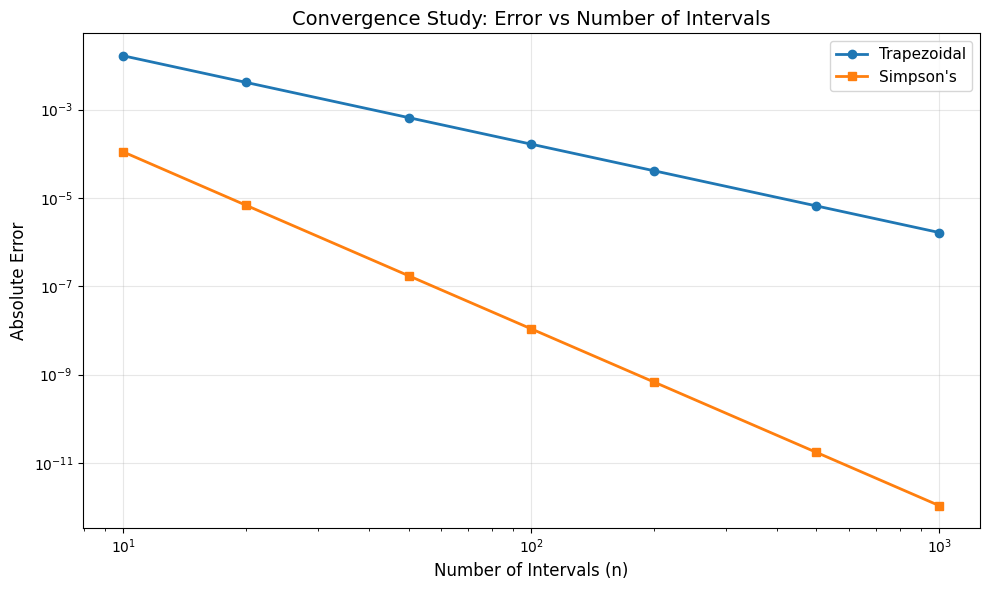


Convergence Rates:
n=  10 to n=  20: Trap=2.00, Simpson=4.01
n=  20 to n=  50: Trap=2.00, Simpson=4.00
n=  50 to n= 100: Trap=2.00, Simpson=4.00
n= 100 to n= 200: Trap=2.00, Simpson=4.00
n= 200 to n= 500: Trap=2.00, Simpson=4.00
n= 500 to n=1000: Trap=2.00, Simpson=4.00

USAGE EXAMPLES

--- Example 1: Integrating x^2 from 0 to 1 ---
Method: Trapezoidal Rule
Value: 0.3333500000
Error Estimate: 4.17e-06
Function Evaluations: 101
Analytical solution: 0.3333333333

--- Example 2: Comparing Different Methods ---
Integrating sin(x) from 0 to 3.141592653589793
Analytical result: 2.0000000000

Trapezoidal Rule:
  Value: 1.9998355039
  Error: 1.64e-04

Simpson's 1/3 Rule:
  Value: 2.0000000108
  Error: 1.08e-08

Romberg (converged at iteration 7):
  Value: 2.0000000000
  Error: 8.88e-16


--- Example 3: Challenging Integral ---
Integrating 1/sqrt(x) from 0.001 to 1 (improper-like)
Method: Romberg (12 iterations)
Value: 1.9367583914
Error Estimate: 6.45e-05
Function Evaluations: 2049
Analytical

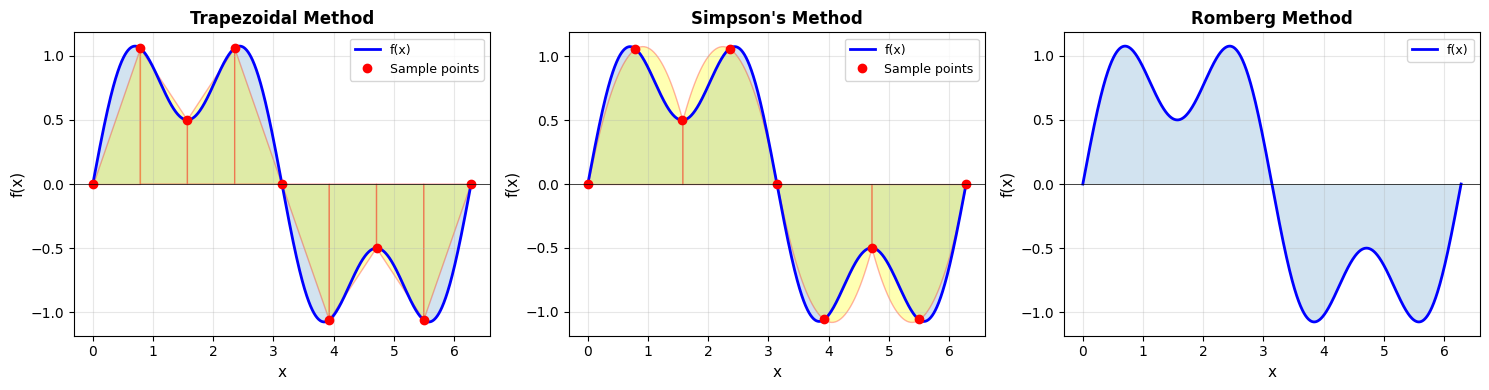


PERFORMANCE COMPARISON

Reference value (high-order Romberg): 0.223083722167

Target Error Level: 1e-6

Method               n/iter     Time (ms)    Error        Evals     
----------------------------------------------------------------------
Trapezoidal          100        0.8926       1.04e-03     101       
Trapezoidal          500        3.9568       4.17e-05     501       
Trapezoidal          1000       7.5989       1.04e-05     1001      
Trapezoidal          5000       38.1162      4.17e-07     5001      

Simpson              100        0.8349       5.44e-06     101       
Simpson              500        4.2565       8.62e-09     501       
Simpson              1000       7.7865       5.38e-10     1001      
Simpson              5000       41.7943      8.61e-13     5001      

Romberg              5          0.0772       3.62e-02     17        
Romberg              8          0.2871       1.85e-08     129       
Romberg              10         1.0307       1.80e-15     513  

In [6]:
# =============================================================================
# Main Execution
# =============================================================================

if __name__ == "__main__":
    print("""
    ╔═══════════════════════════════════════════════════════════════════════╗
    ║          NUMERICAL INTEGRATION FRAMEWORK                              ║
    ║          Object-Oriented Programming Implementation                   ║
    ╚═══════════════════════════════════════════════════════════════════════╝
    """)

    # Run comprehensive tests
    tester = IntegratorTester()
    tester.run_all_tests()

    # Run convergence study
    f = lambda x: np.sin(x)
    analytical = 2.0
    tester.convergence_study(f, 0, np.pi, analytical)

    # Show usage examples
    usage_examples()

    # Performance comparison
    performance_comparison()

    print("\n" + "="*80)
    print("ALL TESTS AND EXAMPLES COMPLETED SUCCESSFULLY!")
    print("="*80)